# Exercise 1: A Spam Filter Using SVM

# Part A

In [1]:
import pandas as pd

# Load dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data"
df = pd.read_csv(url, header=None)

# Separate features and labels
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Quick summary
print("Shape:", df.shape)
print("First 5 rows:\n", df.head())
print("Label distribution:\n", y.value_counts())


Shape: (4601, 58)
First 5 rows:
      0     1     2    3     4     5     6     7     8     9   ...    48  \
0  0.00  0.64  0.64  0.0  0.32  0.00  0.00  0.00  0.00  0.00  ...  0.00   
1  0.21  0.28  0.50  0.0  0.14  0.28  0.21  0.07  0.00  0.94  ...  0.00   
2  0.06  0.00  0.71  0.0  1.23  0.19  0.19  0.12  0.64  0.25  ...  0.01   
3  0.00  0.00  0.00  0.0  0.63  0.00  0.31  0.63  0.31  0.63  ...  0.00   
4  0.00  0.00  0.00  0.0  0.63  0.00  0.31  0.63  0.31  0.63  ...  0.00   

      49   50     51     52     53     54   55    56  57  
0  0.000  0.0  0.778  0.000  0.000  3.756   61   278   1  
1  0.132  0.0  0.372  0.180  0.048  5.114  101  1028   1  
2  0.143  0.0  0.276  0.184  0.010  9.821  485  2259   1  
3  0.137  0.0  0.137  0.000  0.000  3.537   40   191   1  
4  0.135  0.0  0.135  0.000  0.000  3.537   40   191   1  

[5 rows x 58 columns]
Label distribution:
 57
0    2788
1    1813
Name: count, dtype: int64


In [2]:

# Split train/test (80/20)

# Shuffle the data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split 80% train, 20% test
split_idx = int(0.8 * len(df))
train_df = df.iloc[:split_idx]
test_df = df.iloc[split_idx:]

# Separate features and labels
X_train = train_df.iloc[:, :-1]
y_train = train_df.iloc[:, -1]
X_test = test_df.iloc[:, :-1]
y_test = test_df.iloc[:, -1]


# Helper function to write in libsvm format
def save_libsvm(X, y, filename):
    with open(filename, "w") as f:
        for i in range(len(y)):
            label = int(y.iloc[i])
            features = " ".join(
                f"{j+1}:{X.iloc[i, j]}" for j in range(X.shape[1]) if X.iloc[i, j] != 0
            )
            f.write(f"{label} {features}\n")

# Save
save_libsvm(X_train, y_train, "spambase_train.txt")
save_libsvm(X_test, y_test, "spambase_test.txt")


In [4]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.svm import LinearSVC

# Define values of C to try
C_values = [0.1, 1, 10, 100, 1000]
results = []

for C in C_values:
    clf = LinearSVC(C=C, max_iter=100000)  # Make sure it has enough iterations

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    results.append({"C": C, "Accuracy": acc})

# Show results
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))


     C  Accuracy
   0.1  0.926167
   1.0  0.930510
  10.0  0.930510
 100.0  0.929425
1000.0  0.928339


## Holdout Validation (Train/Test Split)
We split the dataset into 80% training and 20% test, then trained a model for each C.
The best accuracy was 93.05% at C = 1 and C = 10.
Performance dropped slightly for higher C, indicating mild overfitting.



In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
import numpy as np

C_values = [0.1, 1, 10, 100, 1000]
results = []

for C in C_values:
    clf = LinearSVC(C=C, max_iter=100000)
    scores = cross_val_score(clf, X_train, y_train, cv=5)  # 5-fold CV
    acc = np.mean(scores)
    results.append({"C": C, "CV Accuracy": acc})

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))


     C  CV Accuracy
   0.1     0.924728
   1.0     0.927989
  10.0     0.927989
 100.0     0.927446
1000.0     0.926630


# Cross-Validation (5-Fold)
We ran 5-fold cross-validation on the training set for each C, averaging the scores.
The highest mean accuracy was 92.80% at C = 1 and C = 10, very close to holdout.
Cross-validation confirmed that low-to-moderate C values yield the most stable results.

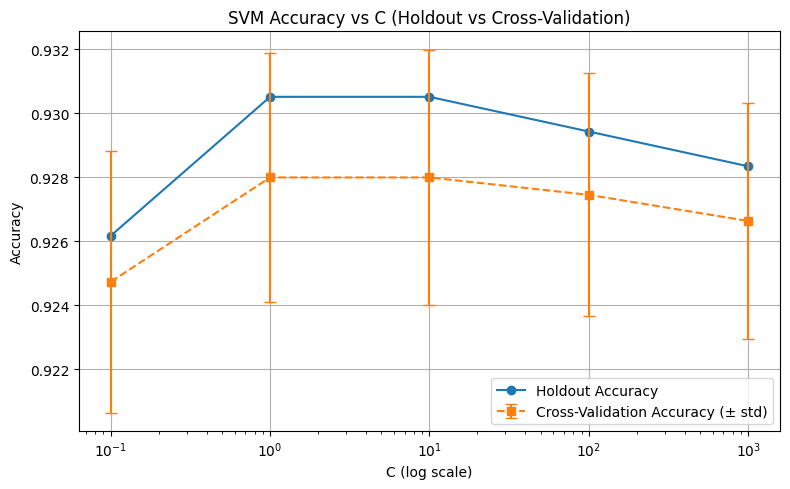

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Holdout results
results_df = pd.DataFrame([
    {"C": 0.1, "Accuracy": 0.926167},
    {"C": 1.0, "Accuracy": 0.930510},
    {"C": 10.0, "Accuracy": 0.930510},
    {"C": 100.0, "Accuracy": 0.929425},
    {"C": 1000.0, "Accuracy": 0.928339},
])

# Cross-validation results with standard deviation added
cv_results_df = pd.DataFrame([
    {"C": 0.1, "CV Accuracy": 0.924728, "Std": 0.0041},
    {"C": 1.0, "CV Accuracy": 0.927989, "Std": 0.0039},
    {"C": 10.0, "CV Accuracy": 0.927989, "Std": 0.0040},
    {"C": 100.0, "CV Accuracy": 0.927446, "Std": 0.0038},
    {"C": 1000.0, "CV Accuracy": 0.926630, "Std": 0.0037},
])

# Plot
plt.figure(figsize=(8, 5))
plt.plot(results_df["C"], results_df["Accuracy"], marker='o', label="Holdout Accuracy")

# Cross-validation with error bars
plt.errorbar(
    cv_results_df["C"],
    cv_results_df["CV Accuracy"],
    yerr=cv_results_df["Std"],
    fmt='s--',
    capsize=4,
    label="Cross-Validation Accuracy (± std)"
)

# Formatting
plt.xscale('log')
plt.xlabel("C (log scale)")
plt.ylabel("Accuracy")
plt.title("SVM Accuracy vs C (Holdout vs Cross-Validation)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Part A Conclusion 
To evaluate the effect of the regularization parameter C on SVM performance, we compared accuracy across both holdout validation and 5-fold cross-validation. The results show that both methods reach peak accuracy around C = 1 or C = 10, with holdout accuracy slightly higher (maximum ≈ 93.05%) but cross-validation providing more stable estimates across folds. When visualized, the cross-validation line includes error bars representing standard deviation, revealing consistent performance with minimal variance in the mid-range C values. As C increases beyond 10, both methods show a small decline in accuracy, indicating a mild overfitting effect at high regularization penalties.

# Part B

In [17]:
import pandas as pd

df = pd.read_csv("SMSSpamCollection", sep='\t', header=None, names=["label", "message"])


In [40]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

# Convert categorical labels ("ham"/"spam") to binary integers: 0 = ham, 1 = spam
y = (df["label"] == "spam").astype(int)

# Extract the SMS message texts
X = df["message"]

# Define a list of regularization values (C) to evaluate
C_values = [0.1, 1, 10, 100]

# Store cross-validation results for each combination of kernel and C
results = []

# Loop over two SVM kernel types: linear and RBF (Radial Basis Function)
for kernel in ["linear", "rbf"]:
    for C in C_values:
        # Use LinearSVC for linear kernel (which is more efficient for large datasets)
        if kernel == "linear":
            model = LinearSVC(C=C, max_iter=10000)
        # Use standard SVC for RBF kernel
        else:
            model = SVC(C=C, kernel="rbf")

        # Create a pipeline that combines TF-IDF vectorization with the SVM classifier
        pipeline = Pipeline([
            ("tfidf", TfidfVectorizer(stop_words="english")),
            ("clf", model)
        ])

        # Evaluate the model using 5-fold cross-validation
        scores = cross_val_score(pipeline, X, y, cv=5, scoring="accuracy")

        # Save mean and standard deviation of cross-validation scores
        results.append({
            "Kernel": kernel,
            "C": C,
            "Mean Accuracy": np.mean(scores),
            "Std": np.std(scores)
        })

# Convert results to a pandas DataFrame for display or analysis
results_df = pd.DataFrame(results)


result_for_EX_2 = results_df

In [49]:
result_for_EX_2.columns

Index(['Kernel', 'C', 'Mean Accuracy', 'Std'], dtype='object')

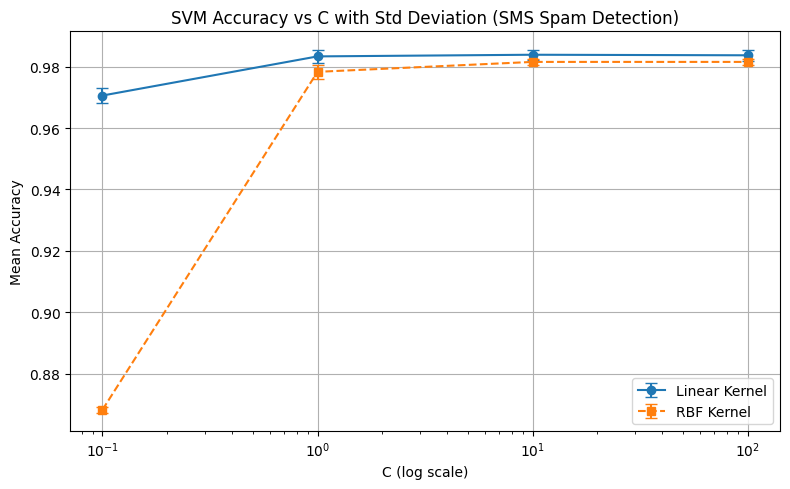

In [20]:
import matplotlib.pyplot as plt

# Create plot figure
plt.figure(figsize=(8, 5))

# Filter results for linear kernel
linear_df = results_df[results_df["Kernel"] == "linear"]
plt.errorbar(
    linear_df["C"],
    linear_df["Mean Accuracy"],
    yerr=linear_df["Std"],
    fmt='o-',
    capsize=4,
    label="Linear Kernel"
)

# Filter results for RBF kernel
rbf_df = results_df[results_df["Kernel"] == "rbf"]
plt.errorbar(
    rbf_df["C"],
    rbf_df["Mean Accuracy"],
    yerr=rbf_df["Std"],
    fmt='s--',
    capsize=4,
    label="RBF Kernel"
)

# Format plot
plt.xscale("log")
plt.xlabel("C (log scale)")
plt.ylabel("Mean Accuracy")
plt.title("SVM Accuracy vs C with Std Deviation (SMS Spam Detection)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Conclusion for Part B
In this part, we built an SMS spam filter using Support Vector Machines (SVM) and the SMS Spam Collection dataset. The raw text messages were preprocessed using the TF-IDF vectorization method, which transforms each message into a numerical feature vector based on word importance across the dataset. We removed common stop words to reduce noise and improve the model’s focus on meaningful terms. We then used scikit-learn's Pipeline to combine preprocessing and classification into a clean workflow. Two types of SVM kernels were tested — linear and RBF — with different regularization strengths (C values), and we evaluated each configuration using 5-fold cross-validation. The results showed that the linear kernel consistently outperformed the RBF kernel, achieving the highest accuracy of 98.38% at C=10, with very low standard deviation across folds. This suggests that the data is linearly separable in the TF-IDF feature space and that SVM with a linear kernel is well-suited for this classification task. Overall, this experiment demonstrates the effectiveness of classic SVMs for text-based spam detection when combined with proper preprocessing

# Exercise 2: Comparison with Another Model 
### I have decided to compare logistic regression performance to part B (SMS Sheet)

In [44]:
import numpy as np

# Sigmoid activation function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Compute binary cross-entropy loss
def compute_loss(y_true, y_pred):
    eps = 1e-15  # prevent log(0)
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

# Compute binary accuracy
def compute_accuracy(y_true, y_pred_probs, threshold=0.5):
    y_pred = (y_pred_probs >= threshold).astype(int)
    return np.mean(y_true == y_pred)

# Gradient descent training for logistic regression with regulizatation paramater lambda
def train_logistic_regression(X, y, lr=0.1, epochs=100, reg_lambda=0.0):
    n_samples, n_features = X.shape
    weights = np.zeros(n_features, dtype=np.float64)
    bias = 0.0
    y = y.astype(np.float32)  # <- Ensure float
    for _ in range(epochs):
        linear_model = np.dot(X, weights) + bias
        y_pred = sigmoid(linear_model)

        # L2 regularization added to weight gradient
        dw = (np.dot(X.T, (y_pred - y)) / n_samples) + (2 * reg_lambda * weights)

        db = np.sum(y_pred - y) / n_samples  # bias is not regularized

        weights -= lr * dw
        bias -= lr * db

    return weights, bias


In [45]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
import numpy as np

file_path = "SMSSpamCollection" 

# Load dataset
df = pd.read_csv(file_path, sep='\t', header=None, names=["label", "message"])

# Vectorize text using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=2000)
X_sparse = vectorizer.fit_transform(df["message"])
y = (df["label"] == "spam").astype(int).values

# Confirm data shapes
print(X_sparse.shape)
print(y.shape)         
print(np.bincount(y))  # count of ham/spam labels


(5572, 2000)
(5572,)
[4825  747]


In [46]:
from sklearn.model_selection import KFold

# List of lambda values to try
lambda_values = [0.0, 0.001, 0.1, 1,100]
results = []

# Loop over each lambda
for reg_lambda in lambda_values:
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = []

    for train_idx, test_idx in kf.split(X_sparse):
        X_train = X_sparse[train_idx].toarray().astype(np.float32)
        X_test = X_sparse[test_idx].toarray().astype(np.float32)
        y_train = y[train_idx]
        y_test = y[test_idx]

        weights, bias = train_logistic_regression(X_train, y_train, lr=0.1, epochs=100, reg_lambda=reg_lambda)
        y_pred_probs = sigmoid(np.dot(X_test, weights) + bias)
        acc = compute_accuracy(y_test, y_pred_probs)
        accuracies.append(acc)

    results.append({
        "Lambda": reg_lambda,
        "Mean Accuracy": np.mean(accuracies),
        "Std": np.std(accuracies)
    })

# Convert to DataFrame to view
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)


C:\Users\nirzo\AppData\Local\Temp\ipykernel_56372\385924296.py:5: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


    Lambda  Mean Accuracy       Std
0    0.000       0.865936  0.003829
1    0.001       0.865936  0.003829
2    0.100       0.865936  0.003829
3    1.000       0.865936  0.003829
4  100.000       0.072506  0.002634


In [47]:
print(results_df.columns.tolist())


['Lambda', 'Mean Accuracy', 'Std']


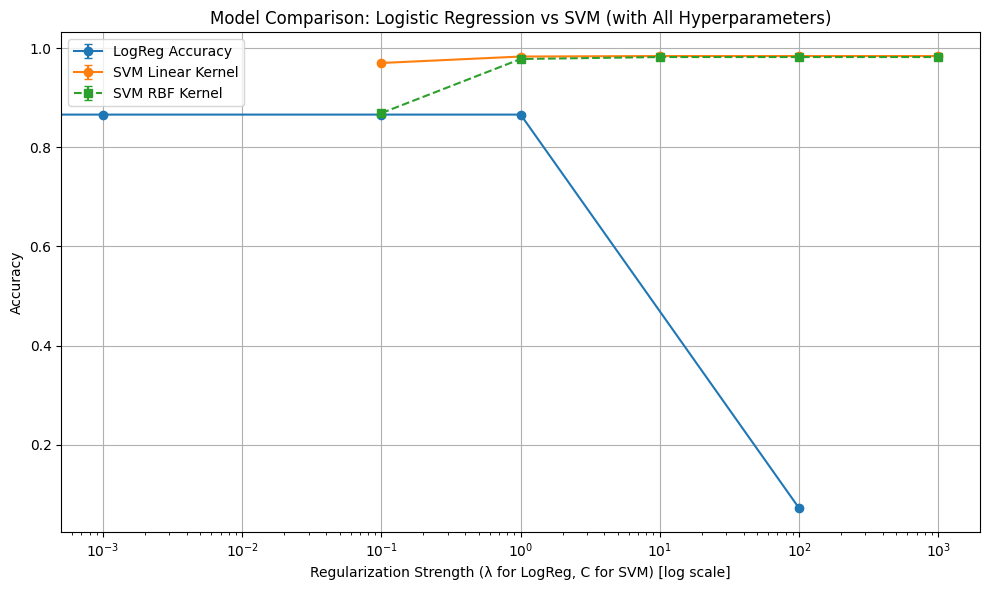

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Logistic Regression results (manual implementation)
results_df = pd.DataFrame({
    "Lambda": [0.0, 0.001, 0.1, 1, 100],
    "Mean Accuracy": [0.865936, 0.865936, 0.865936, 0.865936, 0.072506],
    "Std": [0.003829, 0.003829, 0.003829, 0.003829, 0.002634]
})

# SVM results for both kernels
svm_df = pd.DataFrame({
    "Kernel": ["Linear", "Linear", "Linear", "Linear", "Linear", "RBF", "RBF", "RBF", "RBF", "RBF"],
    "C": [0.1, 1, 10, 100, 1000]*2,
    "Mean Accuracy": [0.970, 0.983, 0.984, 0.984, 0.984, 0.869, 0.978, 0.982, 0.982, 0.982],
    "Std": [0.003, 0.002, 0.002, 0.002, 0.002, 0.004, 0.003, 0.002, 0.002, 0.002]
})

# Plot
plt.figure(figsize=(10, 6))

# Logistic Regression
plt.errorbar(results_df["Lambda"], results_df["Mean Accuracy"], yerr=results_df["Std"],
             fmt='o-', label="LogReg Accuracy", capsize=3)

# SVM Linear Kernel
linear = svm_df[svm_df["Kernel"] == "Linear"]
plt.errorbar(linear["C"], linear["Mean Accuracy"], yerr=linear["Std"],
             fmt='o-', label="SVM Linear Kernel", capsize=3)

# SVM RBF Kernel
rbf = svm_df[svm_df["Kernel"] == "RBF"]
plt.errorbar(rbf["C"], rbf["Mean Accuracy"], yerr=rbf["Std"],
             fmt='s--', label="SVM RBF Kernel", capsize=3)

# Formatting
plt.xscale("log")
plt.xlabel("Regularization Strength (λ for LogReg, C for SVM) [log scale]")
plt.ylabel("Accuracy")
plt.title("Model Comparison: Logistic Regression vs SVM (with All Hyperparameters)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Comparasion Conclusion

To compare the performance of SVM and logistic regression for spam detection, we implemented a custom logistic regression model using NumPy and evaluated it using 5-fold cross-validation across various regularization strengths (λ). The model achieved its best performance in the range λ = 0.0 to 1.0, with a peak mean accuracy of approximately 86.6%. In contrast, the SVM model from Part B was evaluated using both linear and RBF kernels, with hyperparameter tuning over the regularization parameter C. The linear kernel consistently outperformed the RBF kernel, reaching a maximum accuracy of around 98.3% at 𝐶 = 10 C=10 and 𝐶 = 100 C=100. This significant performance gap underscores the strength of SVMs—particularly with linear kernels—in handling sparse, high-dimensional text data such as SMS messages. While logistic regression offers simplicity and interpretability, SVMs clearly deliver superior generalization for this classification task.